# AVRIL V1 Experiment Data Processing


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter

import os
import re

import scipy.stats as stats
import seaborn as sns
import pingouin as pg

## Initial Processing

Time:

- Time is currently organized by STEP. Given a frequency of 100Hz, re-organize into millisecond timesteps starting at zero


In [12]:
data = {}

sampling_rate = 100
step_interval_ms = 1000 / sampling_rate

for participant in os.listdir("Experiment Data"):
    participant_path = os.path.join("Experiment Data", participant)

    # Ignore .DS_Store
    if not os.path.isdir(participant_path):
        continue

    data[participant] = {}

    for csv_file in os.listdir(participant_path):
        file_path = os.path.join(participant_path, csv_file)

        df = pd.read_csv(file_path, encoding='ISO-8859-1', sep=';')

        df['Milliseconds'] = (df.index * step_interval_ms).astype(int)
        data[participant][csv_file] = df

        output_path = os.path.join("Processed CSVs", csv_file)
        df.to_csv(output_path, index=False)

Stopping Sight Distance:

- Add a column for driver's stopping sight distance (SSD) at each time step, calculated based on VI_CarRealTime.Outputs.chassis_velocities.longitudinal
- If Simulink data was available, add a column for SSD - Roundabout.EgoPedEuclideanDistance, where a lower difference is worse
- Source: https://tc.canada.ca/en/rail-transportation/grade-crossings/grade-crossings-handbook/part-c-design-calculations

Acceleration

- Add a column that converts longitudinal acceleration [g] to m/s^2
- This will be used to study the driver's braking deceleration, where 3.4 m/s^2 is considered the safe cutoff


In [13]:
def calculate_SSD(v, f=0.38):
    return ( 0.278 * 2.5 * v ) + ( v**2 / ( 254 * f ) )

def convert_acceleration(g):
    return g * 9.81

In [14]:
for csv_file in os.listdir("Processed CSVs"):
    file_path = os.path.join("Processed CSVs", csv_file)

    # Ignore .DS_Store
    if not os.path.isdir(participant_path):
        continue

    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()

    if 'VI_CarRealTime.Outputs.chassis_velocities.longitudinal' in df.columns:
        df["SSD"] = df['VI_CarRealTime.Outputs.chassis_velocities.longitudinal'].apply(calculate_SSD)
        df["Actual Distance - SSD"] = df["Roundabout.EgoPedEuclideanDistance"] - df["SSD"]
        df["Longitudinal Acceleration"] = df["VI_CarRealTime.Outputs.chassis_accelerations.longitudinal"].apply(convert_acceleration)
        df.to_csv(file_path, index=False)
    else:
        print(f"{csv_file}")

.DS_Store


Independent variable dict.


In [15]:
trial_IVs = {
    1: {
        "Driver's Direction": "Left", 
        "Alert Combination": "Sign 2 + crosswalk", 
        "Pedestrian Crossing": "Straight ahead"
    },
    2: {
        "Driver's Direction": "Straight (left lane)", 
        "Alert Combination": "Crosswalk", 
        "Pedestrian Crossing": "To driver’s left"
    },
    3: {
        "Driver's Direction": "Straight (right lane)", 
        "Alert Combination": "No alert", 
        "Pedestrian Crossing": "To driver’s left"
    },
    4: {
        "Driver's Direction": "Straight (right lane)", 
        "Alert Combination": "Sign 2 + crosswalk", 
        "Pedestrian Crossing": "To driver’s right"
    },
    5: {"Driver's Direction": "Left", 
        "Alert Combination": "Sign 3", 
        "Pedestrian Crossing": "To driver’s left"
    },
    6: {
        "Driver's Direction": "Straight (left lane)", 
        "Alert Combination": "No alert", 
        "Pedestrian Crossing": "To driver’s right"
    },
    7: {
        "Driver's Direction": "Left", 
        "Alert Combination": "Sign 3 + crosswalk", 
        "Pedestrian Crossing": "To driver’s left"
    },
    8: {
        "Driver's Direction": "Left", 
        "Alert Combination": "Sign 3 + crosswalk", 
        "Pedestrian Crossing": "Straight ahead"
    },
    9: {
        "Driver's Direction": "Straight (right lane)", 
        "Alert Combination": "Sign 3", 
        "Pedestrian Crossing": "Straight ahead"
    },
    10: {
        "Driver's Direction": "Right", 
        "Alert Combination": "Crosswalk", 
        "Pedestrian Crossing": "Straight ahead"
    },
    11: {
        "Driver's Direction": "Left", 
        "Alert Combination": "Sign 2", 
        "Pedestrian Crossing": "To driver’s right"
    },
    12: {
        "Driver's Direction": "Right", 
        "Alert Combination": "Sign 3", 
        "Pedestrian Crossing": "To driver’s right"
    },
    13: {
        "Driver's Direction": "Left", 
        "Alert Combination": "Crosswalk", 
        "Pedestrian Crossing": "To driver’s left"
    },
    14: {
        "Driver's Direction": "Right", 
        "Alert Combination": "Sign 2", 
        "Pedestrian Crossing": "To driver’s left"
    },
    15: {
        "Driver's Direction": "Straight (left lane)", 
        "Alert Combination": "Sign 2", 
        "Pedestrian Crossing": "Straight ahead"
    },
}

## SSD Analysis


### Pre-Processing

- Put CSVs in a meaningful format for analyzing SSD (stopping sight distance) vs. actual distance from the pedestrian, around the time when the vehicle approaches the pedestrian.
- We want a larger difference between actual distance & SSD to indicate that the driver had more room to stop
- The entry trigger data didn't end up registering, so start analyzing SSD when the driver is about within braking distance from the pedestrian, and stop analyzing once the driver reaches their minimum distance to the pedestrian (after which SSD is irrelevant)
- Ignoring trials where the driver never encounters the pedestrian (i.e. doesn't ever see the pedestrian)


In [ ]:
relevant_trials = {1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15}

input_dir = "Processed CSVs"
output_dir = "SSD Analysis CSVs"

csv_files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

for file in csv_files:
    match = re.search(r'_(\d+)\.csv$', file)
    if not match:
        print(f"Skipping {file}: Could not extract trial number")
        continue
    
    trial_number = int(match.group(1))

    # Skip irrelevant trials where driver never sees pedestrian
    if trial_number not in relevant_trials:
        print(f"Skipping {file}: Trial {trial_number} is not relevant")
        continue

    file_path = os.path.join(input_dir, file)
    df = pd.read_csv(file_path)

    if "Roundabout.EgoPedEuclideanDistance" not in df.columns:
        print(f"Skipping {file}: Missing required column")
        continue

    # This distance is around 1/4 of the roundabout, where driver might prepare to stop for ped.
    distance_cutoff = 35

    # Filter rows that have both non-zero AND <= cutoff start distance
    valid_start_rows = df[(df["Roundabout.EgoPedEuclideanDistance"] > 0) & 
                          (df["Roundabout.EgoPedEuclideanDistance"] <= distance_cutoff)]
    
    if valid_start_rows.empty:
        print(f"Skipping {file}: Simulink model failed to capture distance from pedestrian")
        continue

    # Get the first row where distance from ped. conditions are met
    start_index = valid_start_rows.index[0]

    df_filtered = df.loc[start_index:]

    min_distance_index = df_filtered["Roundabout.EgoPedEuclideanDistance"].idxmin()

    df_filtered = df.loc[start_index:min_distance_index]

    output_path = os.path.join(output_dir, file)
    df_filtered.to_csv(output_path, index=False)

Skipping Hassan_7.csv: Simulink model failed to capture distance from pedestrian
Skipping Hassan_6.csv: Simulink model failed to capture distance from pedestrian
Skipping Ionel_14.csv: Trial 14 is not relevant
Skipping Hassan_4.csv: Simulink model failed to capture distance from pedestrian
Skipping Adity_10.csv: Trial 10 is not relevant
Skipping Pete_14.csv: Trial 14 is not relevant
Skipping Hassan_5.csv: Simulink model failed to capture distance from pedestrian
Skipping Hassan_1.csv: Simulink model failed to capture distance from pedestrian
Skipping Pete_10.csv: Trial 10 is not relevant
Skipping Adity_14.csv: Trial 14 is not relevant
Skipping Ionel_10.csv: Trial 10 is not relevant
Skipping Hassan_2.csv: Trial 2 is not relevant
Skipping Serena_8.csv: Simulink model failed to capture distance from pedestrian
Skipping Serena_9.csv: Simulink model failed to capture distance from pedestrian
Skipping Hassan_3.csv: Trial 3 is not relevant
Skipping Eric_3.csv: Trial 3 is not relevant
Skipping

### Format for Statistical Analysis

- Compile data into one long-format CSV, with trial number, participant, and independent variable values labeled
- Take the mean Actual - SSD difference for each trial (DV of interest) to see if the alert type (IV of interest) has an affect on this. We'd want to see a higher average in general for a more effective alert.


In [ ]:
input_dir = "SSD Analysis CSVs"
output_file = "Compiled_SSD_Data.csv"

compiled_data = []

csv_files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

for file in csv_files:
    match = re.match(r'(.+?)_(\d+)\.csv$', file)
    if not match:
        print(f"Skipping {file}: Filename does not match expected format.")
        continue

    participant_name, trial_number = match.groups()
    trial_number = int(trial_number)

    if trial_number not in trial_IVs:
        print(f"Skipping {file}: Trial {trial_number} is not in IV mapping.")
        continue

    file_path = os.path.join(input_dir, file)
    
    df = pd.read_csv(file_path)

    if "Actual Distance - SSD" not in df.columns:
        print(f"Skipping {file}: Missing 'Actual Distance - SSD' column.")
        continue

    # Mean of "Actual Distance - SSD" is the DV
    mean_ssd_diff = df["Actual Distance - SSD"].mean()

    # Add columns for independent variable values
    iv_data = trial_IVs[trial_number]

    compiled_data.append({
        "Participant": participant_name,
        "Trial": trial_number,
        "Mean_SSD_Diff": mean_ssd_diff,
        "Driver_Direction": iv_data["Driver's Direction"],
        "Alert_Combination": iv_data["Alert Combination"],
        "Pedestrian_Crossing": iv_data["Pedestrian Crossing"]
    })

compiled_df = pd.DataFrame(compiled_data)

compiled_df.to_csv(output_file, index=False)

### Repeated Measures ANOVA

- Using RM ANOVA since this is a within-subject experiment; all participants go through the same trials while Alert Type changes

First, check normality & sphericity conditions for running RM ANOVA:


Shapiro-Wilk Test for Normality: W=0.9292507767677307, p=8.28512929729186e-05


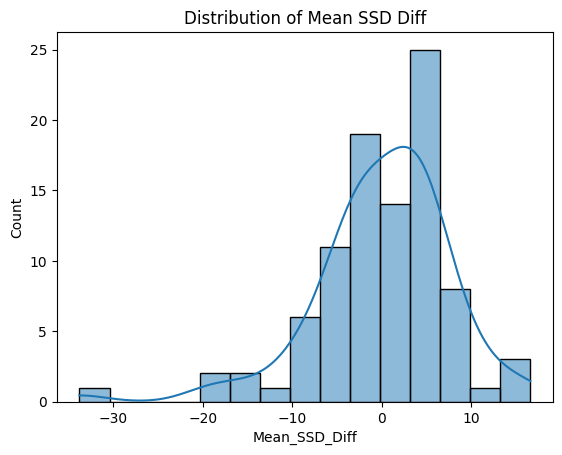

Duplicate entries found:
   Participant   Alert_Combination  Trial  Mean_SSD_Diff
6        Adity              Sign 2     11       9.403737
8        Adity              Sign 2     15       3.227173
44       Adity  Sign 2 + crosswalk      1       9.863128
66       Adity  Sign 2 + crosswalk      4       3.479587
3        Adity              Sign 3     12       3.775771
..         ...                 ...    ...            ...
1         Pete              Sign 3      9       2.837147
14        Pete              Sign 3     12      16.639996
90        Pete              Sign 3      5       4.163962
4         Pete  Sign 3 + crosswalk      8      -0.929530
87        Pete  Sign 3 + crosswalk      7       4.948606

[72 rows x 4 columns]

Missing values in pivoted data:
Alert_Combination
Crosswalk             3
No alert              1
Sign 2                0
Sign 2 + crosswalk    1
Sign 3                1
Sign 3 + crosswalk    1
dtype: int64

Number of participants with complete data: 7

Mauchly's tes

In [31]:
df = pd.read_csv("Compiled_SSD_Data.csv")

# Check normality for Mean SSD Diff using Shapiro-Wilk Test
shapiro_results = stats.shapiro(df["Mean_SSD_Diff"])
print(f"Shapiro-Wilk Test for Normality: W={shapiro_results.statistic}, p={shapiro_results.pvalue}")

sns.histplot(df["Mean_SSD_Diff"], kde=True)
plt.title("Distribution of Mean SSD Diff")
plt.show()

# Pivot data into wide format for RM-ANOVA
df_wide = df.pivot(index="Participant", columns="Trial", values="Mean_SSD_Diff")

# Check if there are duplicates that would cause the pivot to fail
duplicates = df.duplicated(subset=["Participant", "Alert_Combination"], keep=False)
if duplicates.any():
    print("Duplicate entries found:")
    print(df[duplicates][["Participant", "Alert_Combination", "Trial", "Mean_SSD_Diff"]].sort_values(
        by=["Participant", "Alert_Combination"]))

# Use groupby to get the mean value for each participant-alert combination
df_mean = df.groupby(["Participant", "Alert_Combination"])["Mean_SSD_Diff"].mean().reset_index()

df_wide_alert = df_mean.pivot(index="Participant", columns="Alert_Combination", values="Mean_SSD_Diff")

print("\nMissing values in pivoted data:")
print(df_wide_alert.isnull().sum())

df_wide_alert_complete = df_wide_alert.dropna()
print(f"\nNumber of participants with complete data: {len(df_wide_alert_complete)}")

# Check Sphericity with Mauchly's test for Alert_Combination
if len(df_wide_alert_complete) >= 3:  # Need at least 3 participants for test
    sphericity_test = pg.sphericity(df_wide_alert_complete)
    print(f"\nMauchly's test for sphericity (Alert_Combination): {sphericity_test}")
else:
    print("\nNot enough complete cases to perform sphericity test")



Run Repeated-Measures ANOVA:


In [33]:
df = pd.read_csv("Compiled_SSD_Data.csv")

# RM ANOVA with Alert_Combination as the within-subjects factor
anova_results = pg.rm_anova(
    dv="Mean_SSD_Diff", 
    within="Alert_Combination",
    subject="Participant", 
    data=df, 
    detailed=True
)
print("\nRepeated-Measures ANOVA for Alert Combination:\n", anova_results)

# If significant, run post-hoc analysis (analyze significance comparing pairs of IVs)
if anova_results.loc[0, 'p-unc'] < 0.05:
    posthoc = pg.pairwise_ttests(
        dv="Mean_SSD_Diff",
        within="Alert_Combination",
        subject="Participant",
        data=df,
    )
    print("\nPost-hoc tests:\n", posthoc)


Repeated-Measures ANOVA for Alert Combination:
               Source          SS  DF        MS         F     p-unc       ng2  \
0  Alert_Combination  429.893600   5  85.97872  3.413759  0.014683  0.171111   
1              Error  755.578193  30  25.18594       NaN       NaN       NaN   

        eps  
0  0.438622  
1       NaN  

Post-hoc tests:
              Contrast                   A                   B  Paired  \
0   Alert_Combination           Crosswalk            No alert    True   
1   Alert_Combination           Crosswalk              Sign 2    True   
2   Alert_Combination           Crosswalk  Sign 2 + crosswalk    True   
3   Alert_Combination           Crosswalk              Sign 3    True   
4   Alert_Combination           Crosswalk  Sign 3 + crosswalk    True   
5   Alert_Combination            No alert              Sign 2    True   
6   Alert_Combination            No alert  Sign 2 + crosswalk    True   
7   Alert_Combination            No alert              Sign 3    T

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


Box plot to visualize differences:


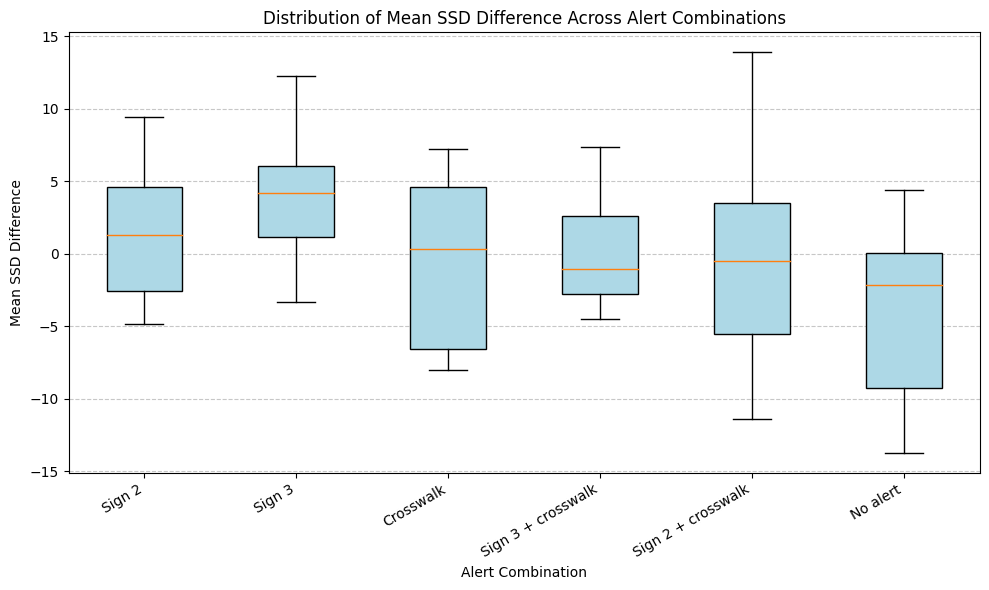

In [ ]:
df = pd.read_csv("Compiled_SSD_Data.csv")

# Categorize data
categories = df["Alert_Combination"].unique()
data_by_category = [df[df["Alert_Combination"] == cat]["Mean_SSD_Diff"].values for cat in categories]

fig, ax = plt.subplots(figsize=(10, 6))

bp = ax.boxplot(data_by_category, patch_artist=True, labels=categories, showfliers=False)

for box in bp['boxes']:
    box.set(facecolor='lightblue')

ax.set_title("Distribution of Mean SSD Difference Across Alert Combinations")
ax.set_xlabel("Alert Combination")
ax.set_ylabel("Mean SSD Difference")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

## Deceleration Analysis


### Pre-processing

- For this test, look only at trials where participants actually needed to brake for the pedestrian
- Around braking distance, extract the minimum acceleration (i.e. hardest deceleration)
- See if certain alerts led to less aggressive braking


In [ ]:
relevant_trials = {5, 9, 13, 15} # trials where braking for pedestrian would've happened

input_dir = "Processed CSVs"
output_dir = "Deceleration Analysis CSVs"

csv_files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

for file in csv_files:
    match = re.search(r'_(\d+)\.csv$', file)
    if not match:
        print(f"Skipping {file}: Could not extract trial number")
        continue
    
    trial_number = int(match.group(1))

    # Skip irrelevant trials where driver does not need to brake for pedestrian
    if trial_number not in relevant_trials:
        print(f"Skipping {file}: Trial {trial_number} is not relevant")
        continue

    file_path = os.path.join(input_dir, file)
    df = pd.read_csv(file_path)

    # Ignore trials where simulink didn't work
    if "Roundabout.EgoPedEuclideanDistance" not in df.columns:
        print(f"Skipping {file}: Missing required column")
        continue

    # This distance is around 1/4 of the roundabout, where driver would prepare to brake
    distance_cutoff = 35

    # Filter rows that have both non-zero AND <= cutoff start distance
    valid_start_rows = df[(df["Roundabout.EgoPedEuclideanDistance"] > 0) & 
                          (df["Roundabout.EgoPedEuclideanDistance"] <= distance_cutoff)]
    
    if valid_start_rows.empty:
        print(f"Skipping {file}: Simulink model failed to capture distance from pedestrian")
        continue

    start_index = valid_start_rows.index[0]

    df_filtered = df.loc[start_index:]

    min_distance_index = df_filtered["Roundabout.EgoPedEuclideanDistance"].idxmin()

    df_filtered = df.loc[start_index:min_distance_index]

    output_path = os.path.join(output_dir, file)
    df_filtered.to_csv(output_path, index=False)

Skipping Hassan_7.csv: Trial 7 is not relevant
Skipping Adity_12.csv: Trial 12 is not relevant
Skipping Pete_8.csv: Trial 8 is not relevant
Skipping Hassan_6.csv: Trial 6 is not relevant
Skipping Ionel_14.csv: Trial 14 is not relevant
Skipping Hassan_4.csv: Trial 4 is not relevant
Skipping Adity_10.csv: Trial 10 is not relevant
Skipping Adity_11.csv: Trial 11 is not relevant
Skipping Pete_14.csv: Trial 14 is not relevant
Skipping Hassan_5.csv: Simulink model failed to capture distance from pedestrian
Skipping Hassan_1.csv: Trial 1 is not relevant
Skipping Pete_10.csv: Trial 10 is not relevant
Skipping Ionel_8.csv: Trial 8 is not relevant
Skipping Adity_14.csv: Trial 14 is not relevant
Skipping Pete_11.csv: Trial 11 is not relevant
Skipping Ionel_12.csv: Trial 12 is not relevant
Skipping Ionel_10.csv: Trial 10 is not relevant
Skipping Hassan_2.csv: Trial 2 is not relevant
Skipping Serena_8.csv: Trial 8 is not relevant
Skipping Serena_9.csv: Simulink model failed to capture distance from

### Format for Statistical Analysis


In [22]:
input_dir = "Deceleration Analysis CSVs"
output_file = "Compiled_Deceleration_Data.csv"

compiled_data = []

csv_files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

for file in csv_files:
    match = re.match(r'(.+?)_(\d+)\.csv$', file)
    if not match:
        print(f"Skipping {file}: Filename does not match expected format.")
        continue

    participant_name, trial_number = match.groups()
    trial_number = int(trial_number)

    if trial_number not in trial_IVs:
        print(f"Skipping {file}: Trial {trial_number} is not in IV mapping.")
        continue

    file_path = os.path.join(input_dir, file)
    
    df = pd.read_csv(file_path)

    if "Longitudinal Acceleration" not in df.columns:
        print(f"Skipping {file}: Missing 'Longitudinal Acceleration' column.")
        continue

    # Compute minimum acceleration within time window (most intense braking deceleration)
    min_acceleration = df["Longitudinal Acceleration"].min()

    # Add columns for independent variable values
    iv_data = trial_IVs[trial_number]

    compiled_data.append({
        "Participant": participant_name,
        "Trial": trial_number,
        "Min_Acceleration": min_acceleration,
        "Driver_Direction": iv_data["Driver's Direction"],
        "Alert_Combination": iv_data["Alert Combination"],
        "Pedestrian_Crossing": iv_data["Pedestrian Crossing"]
    })

compiled_df = pd.DataFrame(compiled_data)

compiled_df.to_csv(output_file, index=False)

### Repeated Measures ANOVA


Shapiro-Wilk Test for Normality: W=0.921677827835083, p=0.0230927225202322


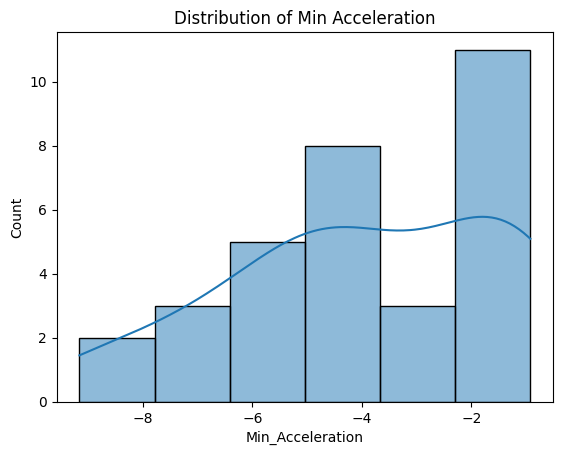

Duplicate entries found:
   Participant Alert_Combination  Trial  Min_Acceleration
8        Adity            Sign 3      9         -4.413603
22       Adity            Sign 3      5         -0.977612
13      Calvin            Sign 3      5         -1.995164
16      Calvin            Sign 3      9         -2.528739
9         Carl            Sign 3      9         -5.218915
23        Carl            Sign 3      5         -4.144898
10        Eric            Sign 3      5         -1.217628
17        Eric            Sign 3      9         -1.275463
6        Ionel            Sign 3      9         -7.033176
26       Ionel            Sign 3      5         -5.945206
12      Madhav            Sign 3      5         -6.033817
14      Madhav            Sign 3      9         -1.459645
11     Mayurah            Sign 3      9         -2.935150
18     Mayurah            Sign 3      5         -9.160301
1         Pete            Sign 3      9         -5.717325
30        Pete            Sign 3      5        

In [ ]:
df = pd.read_csv("Compiled_Deceleration_Data.csv")

# Check normality using Shapiro-Wilk Test
shapiro_results = stats.shapiro(df["Min_Acceleration"])
print(f"Shapiro-Wilk Test for Normality: W={shapiro_results.statistic}, p={shapiro_results.pvalue}")

sns.histplot(df["Min_Acceleration"], kde=True)
plt.title("Distribution of Min Acceleration")
plt.show()

# Check if there are duplicates that would cause the pivot to fail
duplicates = df.duplicated(subset=["Participant", "Alert_Combination"], keep=False)
if duplicates.any():
    print("Duplicate entries found:")
    print(df[duplicates][["Participant", "Alert_Combination", "Trial", "Min_Acceleration"]].sort_values(
        by=["Participant", "Alert_Combination"]))

# Use groupby to get the mean value for each participant-alert combination
df_mean = df.groupby(["Participant", "Alert_Combination"])["Min_Acceleration"].mean().reset_index()

df_wide_alert = df_mean.pivot(index="Participant", columns="Alert_Combination", values="Min_Acceleration")

print("\nMissing values in pivoted data:")
print(df_wide_alert.isnull().sum())

df_wide_alert_complete = df_wide_alert.dropna()
print(f"\nNumber of participants with complete data: {len(df_wide_alert_complete)}")

# Check Sphericity with Mauchly's test for Alert_Combination
if len(df_wide_alert_complete) >= 3:  # Need 3 participants for test
    sphericity_test = pg.sphericity(df_wide_alert_complete)
    print(f"\nMauchly's test for sphericity (Alert_Combination): {sphericity_test}")
else:
    print("\nNot enough complete cases to perform sphericity test")

In [24]:
df = pd.read_csv("Compiled_Deceleration_Data.csv")

# Run repeated measures ANOVA with Alert_Combination as the within-subjects factor
anova_results = pg.rm_anova(
    dv="Min_Acceleration", 
    within="Alert_Combination",
    subject="Participant", 
    data=df, 
    detailed=True
)
print("\nRepeated-Measures ANOVA for Alert Combination:\n", anova_results)

# If significant, run post-hoc tests
if anova_results.loc[0, 'p-unc'] < 0.05:
    posthoc = pg.pairwise_ttests(
        dv="Min_Acceleration",
        within="Alert_Combination",
        subject="Participant",
        data=df,
    )
    print("\nPost-hoc tests:\n", posthoc)


Repeated-Measures ANOVA for Alert Combination:
               Source         SS  DF        MS         F     p-unc       ng2  \
0  Alert_Combination   4.704296   2  2.352148  0.596349  0.566351  0.038126   
1              Error  47.330993  12  3.944249       NaN       NaN       NaN   

        eps  
0  0.994418  
1       NaN  


Visualization:


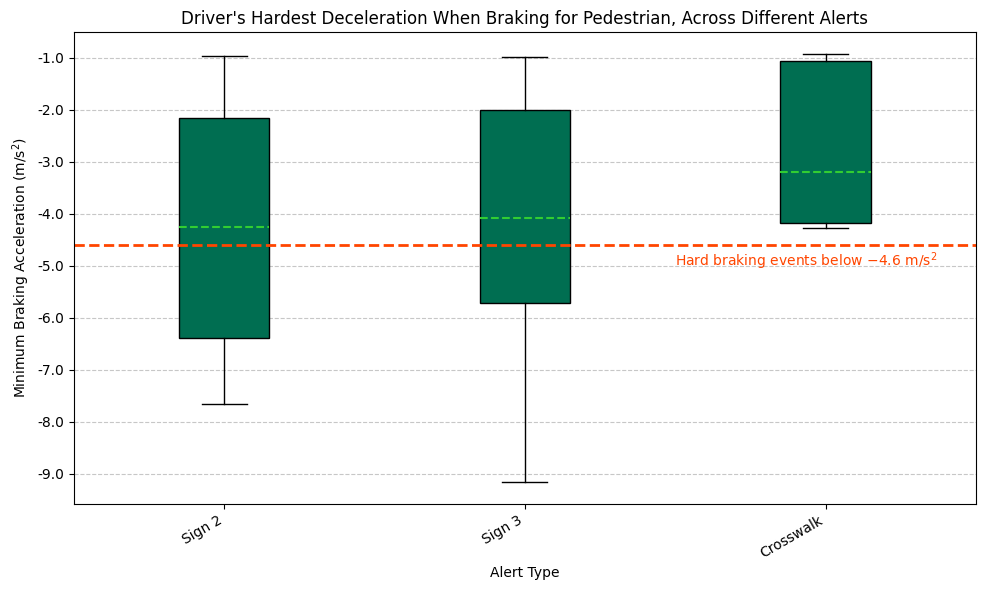

In [48]:
df = pd.read_csv("Compiled_Deceleration_Data.csv")

categories = df["Alert_Combination"].unique()
data_by_category = [df[df["Alert_Combination"] == cat]["Min_Acceleration"].values for cat in categories]

fig, ax = plt.subplots(figsize=(10, 6))

bp = ax.boxplot(
    data_by_category, 
    patch_artist=True, 
    labels=categories, 
    showfliers=False, 
    meanline=True, 
    showmeans=True,
)

for box in bp['boxes']:
    box.set(facecolor='#006E51', edgecolor='black')

for median in bp['medians']:
    median.set(color='none')

for mean in bp['means']:
    mean.set(color="limegreen", linewidth=1.5)

# Add Risk Threshold Line
risk_level = -4.6
ax.axhline(y=risk_level, color='orangered', linestyle='--', linewidth=2, label="Risk Threshold")

ax.text(
    x=len(categories) - 0.5,
    y=risk_level - 0.4,
    s=r"Hard braking events below $-4.6 \ \mathrm{m/s^2}$", 
    color="orangered",
    fontsize=10,
)

ax.yaxis.set_major_locator(MultipleLocator(1.0))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.set_title("Driver's Hardest Deceleration When Braking for Pedestrian, Across Different Alerts")
ax.set_xlabel("Alert Type")
ax.set_ylabel(r"Minimum Braking Acceleration ($\mathrm{m/s^2}$)")

plt.xticks(rotation=30, ha="right", fontsize=10)

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

## Velocity Analysis


### Pre-processing

- In this test, compare mean velocity for different alerts while driver moves through roundabout
- Ignored right turns this time since you're not navigating the roundabout


In [ ]:
relevant_trials = {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 15} # non right-turn trials

input_dir = "Processed CSVs"
output_dir = "Velocity Analysis CSVs"

csv_files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

for file in csv_files:
    match = re.search(r'_(\d+)\.csv$', file)
    if not match:
        print(f"Skipping {file}: Could not extract trial number")
        continue
    
    trial_number = int(match.group(1))

    # Skip right turn trials since driver doesn't move through the roundabout
    if trial_number not in relevant_trials:
        print(f"Skipping {file}: Trial {trial_number} is not relevant")
        continue

    file_path = os.path.join(input_dir, file)
    df = pd.read_csv(file_path)

    if "Roundabout.EgoPedEuclideanDistance" not in df.columns:
        print(f"Skipping {file}: Missing required column")
        continue

    # 50m is around half of the roundabout, so 1 straight pass or the meaningful part of 1 left pass
    distance_cutoff = 50

    # Filter rows that have both non-zero AND <= cutoff start distance
    valid_start_rows = df[(df["Roundabout.EgoPedEuclideanDistance"] > 0) & 
                          (df["Roundabout.EgoPedEuclideanDistance"] <= distance_cutoff)]
    
    if valid_start_rows.empty:
        print(f"Skipping {file}: Simulink model failed to capture distance from pedestrian")
        continue

    # Get the first row where distance from ped. conditions are met
    start_index = valid_start_rows.index[0]

    df_filtered = df.loc[start_index:]

    min_distance_index = df_filtered["Roundabout.EgoPedEuclideanDistance"].idxmin()

    df_filtered = df.loc[start_index:min_distance_index]

    output_path = os.path.join(output_dir, file)
    df_filtered.to_csv(output_path, index=False)

Skipping Hassan_7.csv: Simulink model failed to capture distance from pedestrian
Skipping Adity_12.csv: Trial 12 is not relevant
Skipping Hassan_6.csv: Simulink model failed to capture distance from pedestrian
Skipping Ionel_14.csv: Trial 14 is not relevant
Skipping Hassan_4.csv: Simulink model failed to capture distance from pedestrian
Skipping Adity_10.csv: Trial 10 is not relevant
Skipping Pete_14.csv: Trial 14 is not relevant
Skipping Hassan_5.csv: Simulink model failed to capture distance from pedestrian
Skipping Hassan_1.csv: Simulink model failed to capture distance from pedestrian
Skipping Pete_10.csv: Trial 10 is not relevant
Skipping Adity_14.csv: Trial 14 is not relevant
Skipping Ionel_12.csv: Trial 12 is not relevant
Skipping Ionel_10.csv: Trial 10 is not relevant
Skipping Hassan_2.csv: Simulink model failed to capture distance from pedestrian
Skipping Serena_8.csv: Simulink model failed to capture distance from pedestrian
Skipping Serena_9.csv: Simulink model failed to cap

### Format for Statistical Analysis


In [ ]:
input_dir = "Velocity Analysis CSVs"
output_file = "Compiled_Velocity_Data.csv"

compiled_data = []

csv_files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

for file in csv_files:
    match = re.match(r'(.+?)_(\d+)\.csv$', file)
    if not match:
        print(f"Skipping {file}: Filename does not match expected format.")
        continue

    participant_name, trial_number = match.groups()
    trial_number = int(trial_number)

    if trial_number not in trial_IVs:
        print(f"Skipping {file}: Trial {trial_number} is not in IV mapping.")
        continue

    file_path = os.path.join(input_dir, file)
    
    df = pd.read_csv(file_path)

    # Compute mean velocity while within roundabout
    avg_velocity = df["VI_CarRealTime.Outputs.chassis_velocities.longitudinal"].mean()

    # Add columns for independent variable values
    iv_data = trial_IVs[trial_number]

    compiled_data.append({
        "Participant": participant_name,
        "Trial": trial_number,
        "Avg_Velocity": avg_velocity,
        "Driver_Direction": iv_data["Driver's Direction"],
        "Alert_Combination": iv_data["Alert Combination"],
        "Pedestrian_Crossing": iv_data["Pedestrian Crossing"]
    })

compiled_df = pd.DataFrame(compiled_data)

compiled_df.to_csv(output_file, index=False)

### Repeated Measures ANOVA


Shapiro-Wilk Test for Normality: W=0.9028201699256897, p=3.2112830012920313e-06


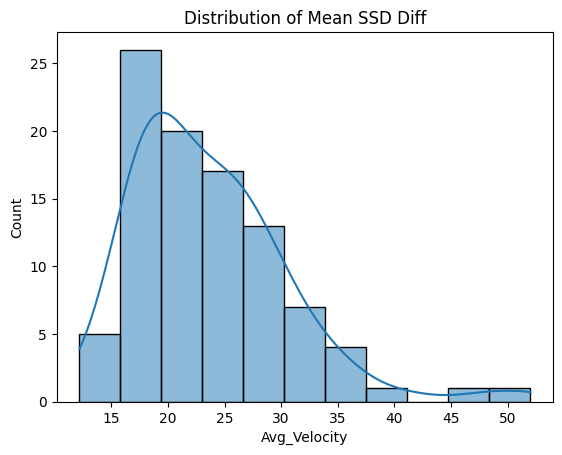

Duplicate entries found:
   Participant   Alert_Combination  Trial  Avg_Velocity
2        Adity           Crosswalk     13     23.603537
52       Adity           Crosswalk      2     40.847140
53       Adity            No alert      3     26.665062
63       Adity            No alert      6     25.400041
5        Adity              Sign 2     11     16.154100
..         ...                 ...    ...           ...
93        Pete  Sign 2 + crosswalk      4     12.191737
1         Pete              Sign 3      9     18.852077
91        Pete              Sign 3      5     17.517280
3         Pete  Sign 3 + crosswalk      8     26.865986
88        Pete  Sign 3 + crosswalk      7     15.489258

[80 rows x 4 columns]

Missing values in pivoted data:
Alert_Combination
Crosswalk             1
No alert              1
Sign 2                0
Sign 2 + crosswalk    1
Sign 3                1
Sign 3 + crosswalk    1
dtype: int64

Number of participants with complete data: 9

Mauchly's test for spheri

In [ ]:
df = pd.read_csv("Compiled_Velocity_Data.csv")

# Check normality using Shapiro-Wilk Test
shapiro_results = stats.shapiro(df["Avg_Velocity"])
print(f"Shapiro-Wilk Test for Normality: W={shapiro_results.statistic}, p={shapiro_results.pvalue}")

sns.histplot(df["Avg_Velocity"], kde=True)
plt.title("Distribution of Mean SSD Diff")
plt.show()

# Pivot data into wide format for RM-ANOVA
df_wide = df.pivot(index="Participant", columns="Trial", values="Avg_Velocity")

duplicates = df.duplicated(subset=["Participant", "Alert_Combination"], keep=False)
if duplicates.any():
    print("Duplicate entries found:")
    print(df[duplicates][["Participant", "Alert_Combination", "Trial", "Avg_Velocity"]].sort_values(
        by=["Participant", "Alert_Combination"]))

df_mean = df.groupby(["Participant", "Alert_Combination"])["Avg_Velocity"].mean().reset_index()

df_wide_alert = df_mean.pivot(index="Participant", columns="Alert_Combination", values="Avg_Velocity")

print("\nMissing values in pivoted data:")
print(df_wide_alert.isnull().sum())

df_wide_alert_complete = df_wide_alert.dropna()
print(f"\nNumber of participants with complete data: {len(df_wide_alert_complete)}")

# Check Sphericity with Mauchly's test for Alert_Combination
if len(df_wide_alert_complete) >= 3:
    sphericity_test = pg.sphericity(df_wide_alert_complete)
    print(f"\nMauchly's test for sphericity (Alert_Combination): {sphericity_test}")
else:
    print("\nNot enough complete cases to perform sphericity test")



In [ ]:
df = pd.read_csv("Compiled_Velocity_Data.csv")

# Run repeated measures ANOVA with Alert_Combination as the within-subjects factor
anova_results = pg.rm_anova(
    dv="Avg_Velocity", 
    within="Alert_Combination",
    subject="Participant", 
    data=df, 
    detailed=True,
    correction=True # Since sphericity failed, need to apply correction
)
print("\nRepeated-Measures ANOVA for Alert Combination:\n", anova_results)

# If significant, run post-hoc tests
if anova_results.loc[0, 'p-unc'] < 0.05:
    posthoc = pg.pairwise_ttests(
        dv="Avg_Velocity",
        within="Alert_Combination",
        subject="Participant",
        data=df,
    )
    print("\nPost-hoc tests:\n", posthoc)


Repeated-Measures ANOVA for Alert Combination:
               Source           SS  DF          MS         F     p-unc  \
0  Alert_Combination   502.184524   5  100.436905  2.896967  0.025258   
1              Error  1386.786909  40   34.669673       NaN       NaN   

   p-GG-corr       ng2       eps sphericity   W-spher  p-spher  
0   0.093897  0.198211  0.348639      False  0.003093  0.00233  
1        NaN       NaN       NaN        NaN       NaN      NaN  

Post-hoc tests:
              Contrast                   A                   B  Paired  \
0   Alert_Combination           Crosswalk            No alert    True   
1   Alert_Combination           Crosswalk              Sign 2    True   
2   Alert_Combination           Crosswalk  Sign 2 + crosswalk    True   
3   Alert_Combination           Crosswalk              Sign 3    True   
4   Alert_Combination           Crosswalk  Sign 3 + crosswalk    True   
5   Alert_Combination            No alert              Sign 2    True   
6   Ale

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packa

Visualize:


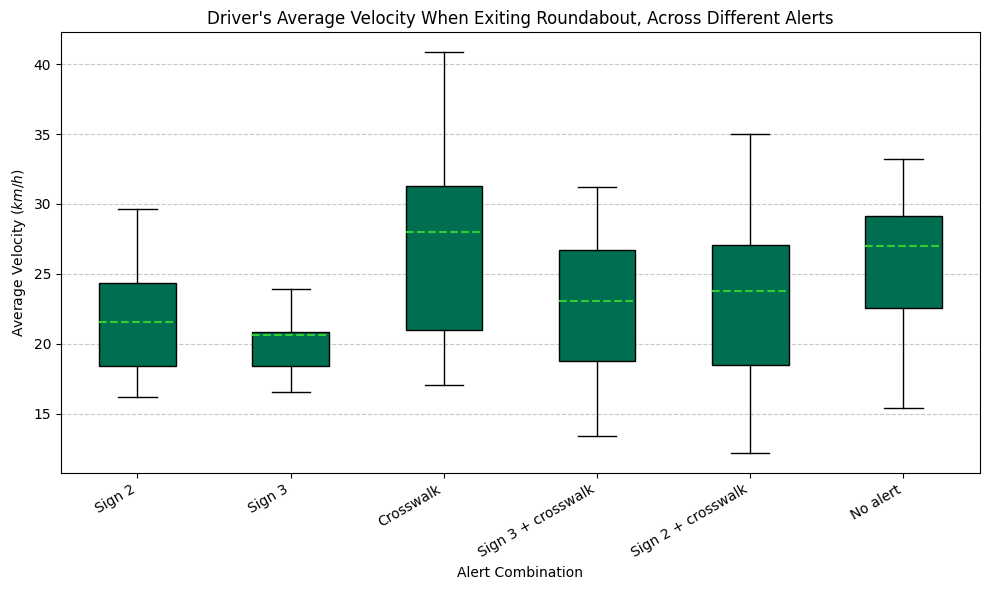

In [49]:
df = pd.read_csv("Compiled_Velocity_Data.csv")

categories = df["Alert_Combination"].unique()
data_by_category = [df[df["Alert_Combination"] == cat]["Avg_Velocity"].values for cat in categories]

fig, ax = plt.subplots(figsize=(10, 6))

bp = ax.boxplot(
    data_by_category, 
    patch_artist=True, 
    labels=categories, 
    showfliers=False, 
    meanline=True, 
    showmeans=True,
)

for box in bp['boxes']:
    box.set(facecolor='#006E51', edgecolor='black')

for median in bp['medians']:
    median.set(color='none')

for mean in bp['means']:
    mean.set(color="limegreen", linewidth=1.5)

ax.yaxis.set_major_locator(MultipleLocator(5))

ax.set_title("Driver's Average Velocity When Exiting Roundabout, Across Different Alerts")
ax.set_xlabel("Alert Combination")
ax.set_ylabel(r"Average Velocity (${km/h}$)")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()